Import the necessary libraries

In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

from Control_Response_Evaluator import Control_Response_Evaluator
from Track import Track

import the track and plot it - default is going to be laguna seca but I have a few circles to see what speeds can be held at varius radius of curvatures.

c:\Users\sgtas\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


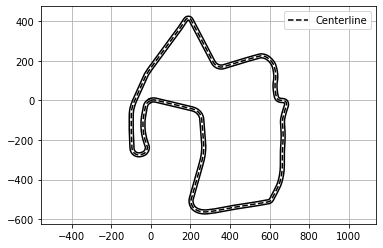

In [2]:
# import track class and data
laguna_seca = "../data/track_data.csv"
test_circle_10m = "../data/test_circle_10.0_radius.csv"
test_circle_50m = "../data/test_circle_50.0_radius.csv"
test_circle_100m = "../data/test_circle_100m_radius.csv"
track = Track(laguna_seca)
plt.rcParams['figure.figsize'] = [10, 7]
track.plot_track()

below i print out the track class's track_df (track data frame from the Pandas library). 

Columns are:
* x = x position in meters - the center position is the start location of the track, I don't think this is the actual start location of the race but it was the start location of the osm edge that defined the track. To get position in meters I parsed the OSM file and got all the points in lat/lon. I then found the mean of all the points and set that as the track center. I then got the distance in meters and angle from the track center to each point along the track using the haversine equation / sphereoidal world model and used these to calculate the position of each point in meters with respect to the track center. Then, to make testing easier I subtracted the start location to reset the track origin to the start point of the osm track. 
* y = y position in meters with respect to the start
* z = z position in meters with respect to the start
* xn = x position in meters of the NEXT point with respect to the start - I don't know that we actually need this anymore, it was used to calc UV, heading
* yn = y position in meters of the NEXT point with respect to the start
* zn = z position in meters of the NEXT point with respect to the start
* heading = direction to the next point off of East - East was not deliberately chosen
* dist = distance to next point on the track in meters
* inner_x = estimate of the inner edge of the track based on the UV, x/y being the center of the track, and track width
* inner_y = estimate of the inner edge of the track
* outer_x = estimate of the outer edge of the track
* outer_y = estimate of the outer edge of the track

In [3]:
track.track_df

,x,y,z,xn,yn,zn,heading,dist,uv,cum_dist,inner_x,inner_y,outer_x,outer_y
0,0.000000,0.000000,0.000000e+00,5.707087,1.701566,-3.922196e-09,0.289758,5.955348,[0.95831294 0.28572069],0.000000,-2.857207,9.583129,2.857207,-9.583129
1,5.707087,1.701566,-3.922196e-09,11.565976,2.635669,-3.379810e-08,0.158103,5.932885,[0.98752776 0.15744498],5.932885,4.132637,11.576844,7.281536,-8.173712
2,11.565976,2.635669,-3.379810e-08,17.406966,2.524249,-9.678956e-08,-0.019073,5.842053,[ 0.99981811 -0.01907207],11.774939,11.756696,12.633850,11.375255,-7.362512
3,17.406966,2.524249,-9.678956e-08,23.256868,1.778842,-2.228262e-01,-0.126739,5.897201,[ 0.99197935 -0.12640005],17.672140,18.670967,12.444042,16.142966,-7.395544
4,23.256868,1.778842,-2.228262e-01,152.704940,-29.078530,-1.444931e+00,-0.234009,133.075094,[ 0.97274454 -0.23187939],150.747234,25.575662,11.506288,20.938074,-7.948603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-22.471548,-18.195817,5.667390e+00,-19.184691,-13.524433,5.667390e+00,0.957648,5.711852,[0.57544504 0.81784046],3572.202401,-30.649953,-12.441367,-14.293144,-23.950267
201,-19.184691,-13.524433,5.667390e+00,-15.192293,-9.386960,6.666662e+00,0.803241,5.749602,[0.69437819 0.71961026],3577.952003,-26.380794,-6.580651,-11.988589,-20.468215
202,-15.192293,-9.386960,6.666662e+00,-10.547934,-5.594311,6.666662e+00,0.684790,5.996187,[0.77455205 0.63251017],3583.948190,-21.517395,-1.641440,-8.867191,-17.132481
203,-10.547934,-5.594311,6.666662e+00,-5.430248,-2.424543,-2.189967e-08,0.554544,6.019812,[0.8501405 0.52655592],3589.968002,-15.813493,2.907094,-5.282375,-14.095716


Load the car components:
* PID_Controller - simple proportional, integral, derivative controller - for the most part I just PD right now and it is contained in the CarController class
* CarParameters - description of the car to allow us to change out different cars
* SimulatedCarState - this is the simulation of the car that contains and propagates the states based on the inputs we receive
* CarController - this contains PID controllers for the speed and heading/steering of the vehicle

In [4]:
from PID_Controller import PID
from CarParameters import CarParam
from SimulatedCarState import SimulatedCarState
from CarController import CarController
    
cre = Control_Response_Evaluator()
carParams = CarParam()
controller = CarController()
mph_to_mps = 0.44704

Run a test lap

In [5]:
# initialize the car's state
x = np.array([track.track_df['x'][0], #0 - x position
                0, #1 - x speed
                track.track_df['y'][0], #2 - y position
                0, #3 - y speed 
                0.0, #4 - forward speed
                0, #5 - forward acceleration
                0, #6 - forward jerk
                track.track_df['heading'][0], #7 - heading angle
                0, #8 - heading rate
                0, #9 - steering angle
                0]) #10 - steering rate


car = SimulatedCarState(x, carParams)

# tune the controller
controller.speed_pid.kp = 2.0
# controller.speed_pid.ki = 0.01
# steering
controller.steer_pid.kp = 8.0
controller.steer_pid.kd = 500.0
# cross track
cross_track_error_gain = 3.0
cross_track_error_soft = 1.0

'''THIS IS WHERE I TUNE THE TRACK SPEEDS'''
# get the radius of curvature for the track and then set the speed limit based on the current carParams' max centripetal acceleration
# this sets the maximum acceleration at any given point but it does not account for the NEXT edge on the track where I might need to go slower
track.get_speed_limits_from_roc(carParams)
# this back propagates speed limits to set the desired speed to ensure that, based on the carParams' max braking, I will be slow enough at the next edge
track.back_propagate_speed_limits_to_set_speed(carParams)
# the above is not great on long straight stretches and it does not try and increase the radius of the corners
'''END WHERE I TUNE TRACK SPEEDS'''

# lot of data logging
times = [] # times
poss = [] # x/y position as points
d_speeds = [] # desired speeds
speeds = [] # speeds
accels = [] # accels
jerks = [] # Brittons :)
sis = [] #steering input
sas = [] # # steering angles
srs = [] # steering rates
has = [] # heading angles
hrs = [] # heading rates
d_has = [] # desired heading angle
ctes = [] # cross track error

t = 0.0 # current time
dt = 0.01 # time step
nearest_edge = 0 # current edge
while nearest_edge < len(track.track_df)-1 and t <180.0:
    # data log current state
    times.append(t)
    poss.append([car.x[car.xi], car.x[car.yi]])
    speeds.append(car.x[car.fsi])
    accels.append(car.x[car.fai])
    jerks.append(car.x[car.fji])
    sas.append(car.x[car.sai])
    srs.append(car.x[car.sri])
    has.append(car.x[car.hai])
    hrs.append(car.x[car.hri])
    
    
    # nearest_edge, cross_track_error = track.find_nearest_edge(car.get_2D_pos())#, nearest_edge)
    nearest_edge, cross_track_error, dist_along_edge = track.find_nearest_edge_with_seed(car.get_2D_pos(), nearest_edge, window_size=2)
    
    # get the desired acceleration from the speed PID controller based on the current speed and the desired speed specificed by the track
    desired_speed = track.track_df['speed'][nearest_edge]
    a_des = controller.speed_pid.tic(car.x[car.fsi], desired_speed)
    d_speeds.append(desired_speed)
    
    # get the desired heading from the track - uses some linear interpolation from adjacent edges to smooth it out some - but it's not great... could be smoother
    desired_heading = track.interp_between_edges(nearest_edge, dist_along_edge, 'heading')
    # ensure that the heading is aligned with the car - if car is at 1deg and track is at 359deg it corrects the track to -1deg to stop the car from turning around
    desired_heading = track.bearing_align(car.x[car.hai], desired_heading)#track.track_df.iloc[nearest_edge]["heading"])
    d_has.append(desired_heading)
    
    # get the desired steering input based on the current car heading and the desired 
    steer_des = controller.steer_pid.tic(car.x[car.hai], desired_heading)
    
    # get the cross track error direction and correction factor
    cross_track_error *= track.find_cross_track_error_to_edge(nearest_edge, car.get_2D_pos())
    cross_track_error_correction = cross_track_error_gain * math.atan(cross_track_error / (cross_track_error_soft + max(desired_speed, car.get_speed())))
    ctes.append(cross_track_error)
    
    # add the desired steering angle based on heading error and cross track error
    steer_input = steer_des + cross_track_error_correction
    sis.append(steer_input)
    
    # give the car the desired acceleration and steering - this does NOT apply them - it just inputs them
    car.input_accel(a_des)
    car.input_steering(steer_input)
    
    # actually update the car model in the simulation
    car.tic(dt)
    
    # update time and provide status to the user
    t += dt
    if t % 25 < dt:
        print("Time: ", int(t), "s - nearest edge: ", nearest_edge, " of ", len(track.track_df)-1)
        
# print out the final lap time
print("lap time: ", t, " s - lap record is: 70.1 s - fastest Miata is 104.7 s - goal is < 120s")

Time:  25 s - nearest edge:  25  of  204
Time:  50 s - nearest edge:  82  of  204
Time:  75 s - nearest edge:  135  of  204
Time:  100 s - nearest edge:  166  of  204
lap time:  115.45000000002216  s - lap record is: 70.1 s - fastest Miata is 104.7 s - goal is < 120s


In [6]:
# plot the whole track and show the position - this is very inefficient and takes quite a while unfortunately
#track.plot_track(points=poss, point_formats=['r.'])

In [7]:
# plot the whole track but only show a portion of it
#track.plot_track(points=poss, point_formats=['r.'], window_center=[50,-50], window_size=150)

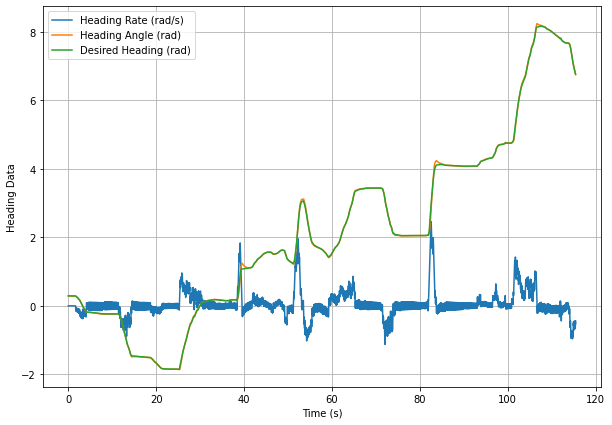

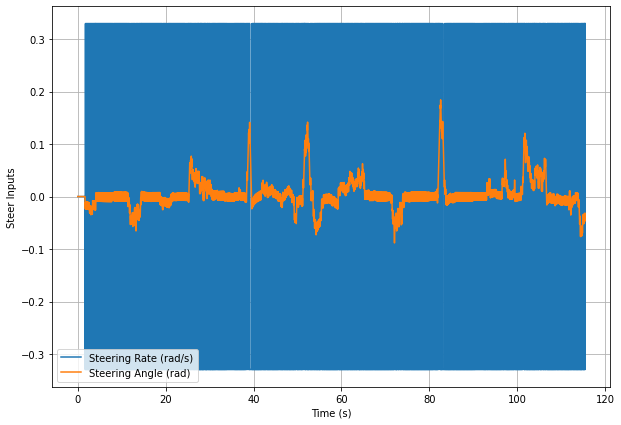

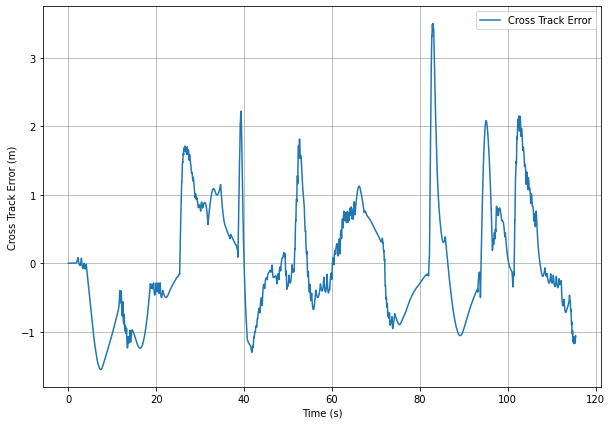

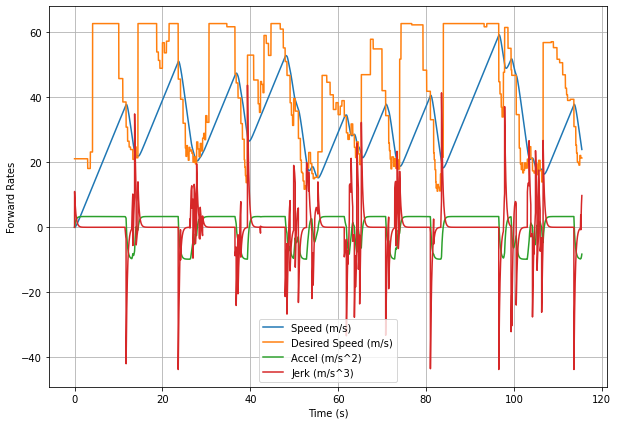

In [8]:
# show some of the data
plt.plot(times, hrs, label='Heading Rate (rad/s)')
plt.plot(times, has, label='Heading Angle (rad)')
plt.plot(times, d_has, label='Desired Heading (rad)')
plt.ylabel('Heading Data')
plt.xlabel('Time (s)')
plt.legend()
plt.grid()
plt.show()


plt.plot(times, srs, label='Steering Rate (rad/s)')
plt.plot(times, sas, label='Steering Angle (rad)')
plt.ylabel('Steer Inputs')
plt.xlabel('Time (s)')
plt.legend()
plt.grid()
plt.show()

plt.plot(times, ctes, label='Cross Track Error')
plt.legend()
plt.ylabel('Cross Track Error (m)')
plt.xlabel('Time (s)')
plt.grid()
plt.show()

# plt.plot(times, xs, label='X Pos')
plt.plot(times, speeds, label='Speed (m/s)')
plt.plot(times, d_speeds, label='Desired Speed (m/s)')
plt.plot(times, accels, label='Accel (m/s^2)')
plt.plot(times, jerks, label='Jerk (m/s^3)')
plt.ylabel('Forward Rates')
plt.xlabel('Time (s)')
plt.legend()
plt.grid()
plt.show()

One of the big things I am noticing is that the steering is very high frequency and not smooth. I can't decide if this is due to the track asking for inconsistend heading OR if the controller needs more tuning. Something to play with